In [30]:
%load_ext autoreload
%autoreload 2

Current device  >>  cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel.utils.inliner import inline
from tqdm import tqdm
from collections import OrderedDict
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model import model_6_v1 as Model
except:
    from .model import model_6_v1 as Model

from pathlib import Path
import multiprocessing
from pprint import pprint
import torch
import math
from matplotlib import pyplot as plt
import yaml

In [32]:
from sklearn.metrics import auc

In [33]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

Current device  >>  cuda


In [34]:
def visualize( model_obj, x1,x2 ):
   
    from sklearn.decomposition import TruncatedSVD
    try :
        %matplotlib inline
    except:
        pass
    import matplotlib.pyplot as plt
    
    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)

    plt.figure(figsize=[10,10])
    plt.scatter(x3[:len(x1),0], x3[:len(x1),1], c='g',alpha=0.95)
    plt.scatter(x3[len(x1):,0], x3[len(x1):,1], c='r',alpha=0.35)
    plt.show()
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter( x3[:len(x1),0], x3[:len(x1),1], x3[:len(x1),2], c ='g',alpha=0.95 , marker='^')
    ax.scatter( x3[len(x1):,0], x3[len(x1):,1], x3[len(x1):,2], c ='r',alpha=0.35 , marker='v')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    return

In [35]:
def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'
    
    with open(config_file, 'r') as fh :
        config = yaml.safe_load(fh)
    config = config[data_set]
    latent_dim = config['ae_latent_dimension']

    data_dict, meta_data_df = data_fetcher.get_data(data_set,True)

    # discrete_columns : { column_name : num_categories }
    discrete_dims = OrderedDict ({k: v for k, v in zip(list(meta_data_df['column']), list(meta_data_df['dimension']))})
    num_discrete_columns = len(discrete_dims)
    count_discrete_dims = 0
    for val in discrete_dims.values():
        if val == 2:
            count_discrete_dims += 1
        else:
            count_discrete_dims += val
            
    real_dims = len(data_dict['train'].columns) - count_discrete_dims

    # ---------------
    # encoder_structure_config['ip_layers']
    # Format :
    # [ 'emb|onehot', num_categories, [ embedding dimension ]
    # ---------------
    encoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'encoder_FCN_to_latent': config['encoder_FCN_to_latent'],
        'ae_latent_dimension' :  config['ae_latent_dimension'],
        'encoder_discrete_xform' : config['encoder_discrete_xform'],
        'encoder_real_xform' : config['encoder_real_xform']
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'decoder_FC_from_latent': config['decoder_FC_from_latent'],
        'decoder_discrete_xform' : config['decoder_discrete_xform'],
        'decoder_real_xform' : config['decoder_real_xform'],
        'ae_latent_dimension': config['ae_latent_dimension']
    }

    # ================
    # Format decoder_field_layers:
    # { idx : [[dim1,dim2], op_activation ]
    # ================
    loss_structure_config = {
        'discrete_dims' : discrete_dims,
        'real_loss_func': config['real_loss_func'],
        'real_dims':  real_dims
    }

    return encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim

encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config('kddcup_neptune')
pprint(encoder_structure_config)
pprint(decoder_structure_config)

Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432
{'ae_latent_dimension': 8,
 'discrete_dims': OrderedDict([('protocol_type', 3),
                               ('service', 65),
                               ('flag', 9),
                               ('land', 2),
                               ('logged_in', 2),
                               ('is_guest_login', 2)]),
 'encoder_FCN_to_latent': {'activation': 'tanh', 'dims': [64, 32]},
 'encoder_discrete_xform': {'service': {'activation': 'none', 'dims': [8]}},
 'encoder_real_xform': {'activation': 'tanh', 'dims': [16]},
 'real_dims': 34}
{'ae_latent_dimension': 8,
 'decoder_FC_from_latent': {'activation': 'tanh', 'dims': [32, 64]},
 'decoder_discrete_xform': {'flag': {'activation': 'tanh', 'dims': None},
                            'is_guest_login': {'activation': 'tanh',
                                               'dims': None},
                            'land': {'activation': 'tanh', 'dims': None},
  

In [36]:
loss_structure_config


{'discrete_dims': OrderedDict([('protocol_type', 3),
              ('service', 65),
              ('flag', 9),
              ('land', 2),
              ('logged_in', 2),
              ('is_guest_login', 2)]),
 'real_loss_func': 'smooth_l1',
 'real_dims': 34}

In [37]:
# ======================================= #
import model_data_fetcher
# ======================================= #

# data_dict, _ = data_fetcher.get_data('kddcup', one_hot=True, num_anom_sets=num_anomaly_sets)


num_anomaly_sets = 5
anomaly_ratio = 0.2

pos, neg_x, data_dict = model_data_fetcher.fetch_model_data('kddcup_neptune',num_anom_sets=num_anomaly_sets,anomaly_ratio=anomaly_ratio)

train_X = data_dict['train']


Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432
Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432
107201 1072010


In [38]:
try:
    from model import model_6_v1_container as Model
except:
    from .model import model_6_v1_container as Model
    
ae_model =  Model(
    DEVICE,
    latent_dim,
    encoder_structure_config,
    decoder_structure_config,
    loss_structure_config,
    batch_size=128,
    learning_rate=0.001,
    max_gamma = 5,
    fc_dropout=0.1,
    ae_dropout=0.2,
    burn_in_epochs=10,
    phase_2_epochs=10,
    phase_3_epochs=10
)

print(ae_model.network_module)

split schema  [3, 65, 9, 1, 1, 1, 34]
Loss structure config {'discrete_dims': OrderedDict([('protocol_type', 3), ('service', 65), ('flag', 9), ('land', 2), ('logged_in', 2), ('is_guest_login', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 34}
 Loss module split schema  [3, 65, 9, 1, 1, 1, 34]
Normal(loc: torch.Size([8]), scale: torch.Size([8]))
model_6_v1(
  (ae_module): AE(
    (encoder): AE_encoder(
      (input_x_form_layers): ModuleList(
        (0): Identity()
        (1): Sequential(
          (0): Linear(in_features=65, out_features=8, bias=True)
          (1): Identity()
        )
        (2): Identity()
        (3): Identity()
        (4): Identity()
        (5): Identity()
        (6): Sequential(
          (0): Linear(in_features=34, out_features=16, bias=True)
          (1): Tanh()
        )
      )
      (FC_z): Sequential(
        (0): Linear(in_features=39, out_features=64, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Tanh()
        (3): Linear(

In [39]:
pos.shape

(75040, 114)

In [40]:
neg_x.shape

(75040, 10, 114)

In [41]:
losses = ae_model.train_model(
    pos, 
    neg_x
)

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch 1 Batch 0 Loss 80.4003 || AE 80.4003 1.3901 
 Epoch 1 Batch 100 Loss 55.5981 || AE 55.5981 1.4043 
 Epoch 1 Batch 200 Loss 55.2793 || AE 55.2793 1.4025 
 Epoch 1 Batch 300 Loss 55.2268 || AE 55.2268 1.4125 
 Epoch 1 Batch 400 Loss 55.1277 || AE 55.1277 1.3936 
 Epoch 1 Batch 500 Loss 55.1727 || AE 55.1727 1.4159 


  3%|▎         | 1/30 [00:35<17:19, 35.85s/it]

Epoch loss :: 56.810417
 Epoch 2 Batch 0 Loss 55.1379 || AE 55.1379 1.4045 
 Epoch 2 Batch 100 Loss 55.1405 || AE 55.1405 1.3966 
 Epoch 2 Batch 200 Loss 55.4532 || AE 55.4532 1.3878 
 Epoch 2 Batch 300 Loss 55.3277 || AE 55.3277 1.4026 
 Epoch 2 Batch 400 Loss 55.4043 || AE 55.4043 1.3971 
 Epoch 2 Batch 500 Loss 55.1907 || AE 55.1907 1.3967 


  7%|▋         | 2/30 [01:12<16:49, 36.05s/it]

Epoch loss :: 55.201534
 Epoch 3 Batch 0 Loss 55.0910 || AE 55.0910 1.4129 
 Epoch 3 Batch 100 Loss 55.1934 || AE 55.1934 1.4081 
 Epoch 3 Batch 200 Loss 55.3221 || AE 55.3221 1.4146 
 Epoch 3 Batch 300 Loss 55.0310 || AE 55.0310 1.4155 
 Epoch 3 Batch 400 Loss 55.2427 || AE 55.2427 1.4134 
 Epoch 3 Batch 500 Loss 55.2662 || AE 55.2662 1.4067 


 10%|█         | 3/30 [01:47<16:05, 35.76s/it]

Epoch loss :: 55.191856
 Epoch 4 Batch 0 Loss 55.2343 || AE 55.2343 1.4099 
 Epoch 4 Batch 100 Loss 55.2449 || AE 55.2449 1.3939 
 Epoch 4 Batch 200 Loss 55.2477 || AE 55.2477 1.3881 
 Epoch 4 Batch 300 Loss 55.1254 || AE 55.1254 1.3978 
 Epoch 4 Batch 400 Loss 55.0662 || AE 55.0662 1.4029 
 Epoch 4 Batch 500 Loss 55.2147 || AE 55.2147 1.4199 


 13%|█▎        | 4/30 [02:21<15:19, 35.37s/it]

Epoch loss :: 55.185963
 Epoch 5 Batch 0 Loss 55.1923 || AE 55.1923 1.4095 
 Epoch 5 Batch 100 Loss 54.5583 || AE 54.5583 1.4003 
 Epoch 5 Batch 200 Loss 54.4192 || AE 54.4192 1.3792 
 Epoch 5 Batch 300 Loss 54.3957 || AE 54.3957 1.3916 
 Epoch 5 Batch 400 Loss 54.4039 || AE 54.4039 1.3844 
 Epoch 5 Batch 500 Loss 54.3880 || AE 54.3880 1.3927 


 17%|█▋        | 5/30 [02:57<14:46, 35.47s/it]

Epoch loss :: 54.468895
 Epoch 6 Batch 0 Loss 54.4057 || AE 54.4057 1.4114 
 Epoch 6 Batch 100 Loss 54.3962 || AE 54.3962 1.3904 
 Epoch 6 Batch 200 Loss 54.4183 || AE 54.4183 1.3948 
 Epoch 6 Batch 300 Loss 54.4072 || AE 54.4072 1.4020 
 Epoch 6 Batch 400 Loss 54.3714 || AE 54.3714 1.3922 
 Epoch 6 Batch 500 Loss 54.3962 || AE 54.3962 1.3902 


 20%|██        | 6/30 [03:34<14:18, 35.77s/it]

Epoch loss :: 54.390804
 Epoch 7 Batch 0 Loss 54.3746 || AE 54.3746 1.3883 
 Epoch 7 Batch 100 Loss 54.3906 || AE 54.3906 1.3877 
 Epoch 7 Batch 200 Loss 54.3735 || AE 54.3735 1.3849 
 Epoch 7 Batch 300 Loss 54.3671 || AE 54.3671 1.3876 
 Epoch 7 Batch 400 Loss 54.4006 || AE 54.4006 1.3874 
 Epoch 7 Batch 500 Loss 54.4120 || AE 54.4120 1.3819 


 23%|██▎       | 7/30 [04:09<13:37, 35.55s/it]

Epoch loss :: 54.387913
 Epoch 8 Batch 0 Loss 54.3712 || AE 54.3712 1.3862 
 Epoch 8 Batch 100 Loss 54.3895 || AE 54.3895 1.3976 
 Epoch 8 Batch 200 Loss 54.3894 || AE 54.3894 1.4105 
 Epoch 8 Batch 300 Loss 54.3639 || AE 54.3639 1.3992 
 Epoch 8 Batch 400 Loss 54.3729 || AE 54.3729 1.3890 
 Epoch 8 Batch 500 Loss 54.4028 || AE 54.4028 1.3829 


 27%|██▋       | 8/30 [04:44<13:02, 35.55s/it]

Epoch loss :: 54.386818
 Epoch 9 Batch 0 Loss 54.3523 || AE 54.3523 1.3832 
 Epoch 9 Batch 100 Loss 54.3777 || AE 54.3777 1.3846 
 Epoch 9 Batch 200 Loss 54.3871 || AE 54.3871 1.4085 
 Epoch 9 Batch 300 Loss 54.3827 || AE 54.3827 1.3843 
 Epoch 9 Batch 400 Loss 54.3578 || AE 54.3578 1.3831 
 Epoch 9 Batch 500 Loss 54.3763 || AE 54.3763 1.3942 


 30%|███       | 9/30 [05:21<12:31, 35.80s/it]

Epoch loss :: 54.386112
 Epoch 10 Batch 0 Loss 1.4019 || AE 54.3621 1.4019 
 Epoch 10 Batch 100 Loss 0.4622 || AE 58.3054 0.4622 
 Epoch 10 Batch 200 Loss 0.2903 || AE 58.1372 0.2903 
 Epoch 10 Batch 300 Loss 0.2155 || AE 58.4473 0.2155 
 Epoch 10 Batch 400 Loss 0.1737 || AE 58.4445 0.1737 
 Epoch 10 Batch 500 Loss 0.1405 || AE 58.3498 0.1405 


 33%|███▎      | 10/30 [06:06<12:54, 38.75s/it]

Epoch loss :: 0.31420907
 Epoch 11 Batch 0 Loss 21.7507 || AE 58.1533 0.3574 
 Epoch 11 Batch 100 Loss 20.6301 || AE 55.3239 0.2775 
 Epoch 11 Batch 200 Loss 20.5499 || AE 55.3079 0.2032 
 Epoch 11 Batch 300 Loss 20.5219 || AE 55.3013 0.1777 
 Epoch 11 Batch 400 Loss 20.5788 || AE 55.5751 0.1339 
 Epoch 11 Batch 500 Loss 20.4140 || AE 55.1620 0.1210 


 37%|███▋      | 11/30 [06:49<12:38, 39.91s/it]

Epoch loss :: 20.496098
 Epoch 12 Batch 0 Loss 7.5828 || AE 55.1833 0.1146 
 Epoch 12 Batch 100 Loss 7.6099 || AE 55.3716 0.1162 
 Epoch 12 Batch 200 Loss 7.5761 || AE 55.2702 0.0961 
 Epoch 12 Batch 300 Loss 7.5541 || AE 55.2288 0.0797 
 Epoch 12 Batch 400 Loss 7.5605 || AE 55.2694 0.0806 
 Epoch 12 Batch 500 Loss 7.5565 || AE 55.3388 0.0672 


 40%|████      | 12/30 [07:30<12:07, 40.40s/it]

Epoch loss :: 7.5320845
 Epoch 13 Batch 0 Loss 2.8131 || AE 55.0890 0.0704 
 Epoch 13 Batch 100 Loss 2.8092 || AE 55.2300 0.0595 
 Epoch 13 Batch 200 Loss 2.8141 || AE 55.2602 0.0629 
 Epoch 13 Batch 300 Loss 2.8078 || AE 55.3046 0.0543 
 Epoch 13 Batch 400 Loss 2.8203 || AE 55.6119 0.0516 
 Epoch 13 Batch 500 Loss 2.8098 || AE 55.5309 0.0451 


 43%|████▎     | 13/30 [08:13<11:38, 41.08s/it]

Epoch loss :: 2.7824304
 Epoch 14 Batch 0 Loss 1.0621 || AE 55.5404 0.0448 
 Epoch 14 Batch 100 Loss 1.0585 || AE 55.2649 0.0463 
 Epoch 14 Batch 200 Loss 1.0550 || AE 55.3231 0.0417 
 Epoch 14 Batch 300 Loss 1.0487 || AE 55.2394 0.0369 
 Epoch 14 Batch 400 Loss 1.0508 || AE 55.4908 0.0344 
 Epoch 14 Batch 500 Loss 1.0467 || AE 55.5210 0.0298 


 47%|████▋     | 14/30 [08:55<10:59, 41.22s/it]

Epoch loss :: 1.0331439
 Epoch 15 Batch 0 Loss 0.4278 || AE 55.5244 0.0537 
 Epoch 15 Batch 100 Loss 0.4061 || AE 55.2940 0.0336 
 Epoch 15 Batch 200 Loss 0.3984 || AE 55.2306 0.0263 
 Epoch 15 Batch 300 Loss 0.4034 || AE 55.4008 0.0301 
 Epoch 15 Batch 400 Loss 0.4015 || AE 55.1912 0.0296 
 Epoch 15 Batch 500 Loss 0.3945 || AE 55.2288 0.0224 


 50%|█████     | 15/30 [09:37<10:22, 41.52s/it]

Epoch loss :: 0.38682732
 Epoch 16 Batch 0 Loss 0.1593 || AE 55.5606 0.0216 
 Epoch 16 Batch 100 Loss 0.1643 || AE 55.6174 0.0265 
 Epoch 16 Batch 200 Loss 0.1548 || AE 55.0362 0.0184 
 Epoch 16 Batch 300 Loss 0.1566 || AE 55.3554 0.0193 
 Epoch 16 Batch 400 Loss 0.1586 || AE 55.6689 0.0206 
 Epoch 16 Batch 500 Loss 0.1584 || AE 54.9786 0.0221 


 53%|█████▎    | 16/30 [10:20<09:48, 42.04s/it]

Epoch loss :: 0.14758869
 Epoch 17 Batch 0 Loss 0.0683 || AE 54.9981 0.0181 
 Epoch 17 Batch 100 Loss 0.0719 || AE 55.0784 0.0216 
 Epoch 17 Batch 200 Loss 0.0655 || AE 55.0035 0.0154 
 Epoch 17 Batch 300 Loss 0.0644 || AE 55.3183 0.0140 
 Epoch 17 Batch 400 Loss 0.0648 || AE 55.2071 0.0145 
 Epoch 17 Batch 500 Loss 0.0683 || AE 55.3611 0.0178 


 57%|█████▋    | 17/30 [11:02<09:06, 42.02s/it]

Epoch loss :: 0.058329813
 Epoch 18 Batch 0 Loss 0.0316 || AE 55.3563 0.0130 
 Epoch 18 Batch 100 Loss 0.0297 || AE 55.0877 0.0112 
 Epoch 18 Batch 200 Loss 0.0327 || AE 55.3289 0.0141 
 Epoch 18 Batch 300 Loss 0.0285 || AE 55.3922 0.0099 
 Epoch 18 Batch 400 Loss 0.0287 || AE 55.4560 0.0101 
 Epoch 18 Batch 500 Loss 0.0294 || AE 55.4648 0.0107 


 60%|██████    | 18/30 [11:43<08:19, 41.65s/it]

Epoch loss :: 0.024769824
 Epoch 19 Batch 0 Loss 0.0161 || AE 55.3822 0.0093 
 Epoch 19 Batch 100 Loss 0.0150 || AE 55.2551 0.0082 
 Epoch 19 Batch 200 Loss 0.0181 || AE 55.3171 0.0113 
 Epoch 19 Batch 300 Loss 0.0202 || AE 55.3635 0.0133 
 Epoch 19 Batch 400 Loss 0.0178 || AE 55.0729 0.0110 
 Epoch 19 Batch 500 Loss 0.0154 || AE 55.4038 0.0085 


 63%|██████▎   | 19/30 [12:25<07:39, 41.75s/it]

Epoch loss :: 0.011893473
 Epoch 20 Batch 0 Loss 0.0079 || AE 55.3698 0.0079 
 Epoch 20 Batch 100 Loss 0.0082 || AE 55.2476 0.0082 
 Epoch 20 Batch 200 Loss 0.0053 || AE 55.2609 0.0053 
 Epoch 20 Batch 300 Loss 0.0040 || AE 55.5584 0.0040 
 Epoch 20 Batch 400 Loss 0.0050 || AE 55.5868 0.0050 
 Epoch 20 Batch 500 Loss 0.0041 || AE 55.6269 0.0041 


 67%|██████▋   | 20/30 [13:08<07:00, 42.06s/it]

Epoch loss :: 0.0056893015
 Epoch 21 Batch 0 Loss 0.0026 || AE 55.2869 0.0026 
 Epoch 21 Batch 100 Loss 0.0022 || AE 55.2760 0.0022 
 Epoch 21 Batch 200 Loss 0.0035 || AE 55.3975 0.0035 
 Epoch 21 Batch 300 Loss 0.0014 || AE 55.3805 0.0014 
 Epoch 21 Batch 400 Loss 0.0017 || AE 55.5510 0.0017 
 Epoch 21 Batch 500 Loss 0.0025 || AE 55.1748 0.0025 


 70%|███████   | 21/30 [13:47<06:11, 41.22s/it]

Epoch loss :: 0.0031933144
 Epoch 22 Batch 0 Loss 0.0017 || AE 55.1419 0.0017 
 Epoch 22 Batch 100 Loss 0.0018 || AE 55.0672 0.0018 
 Epoch 22 Batch 200 Loss 0.0016 || AE 55.2942 0.0016 
 Epoch 22 Batch 300 Loss 0.0032 || AE 55.6822 0.0032 
 Epoch 22 Batch 400 Loss 0.0019 || AE 55.1591 0.0019 
 Epoch 22 Batch 500 Loss 0.0029 || AE 55.4810 0.0029 


 73%|███████▎  | 22/30 [14:27<05:27, 40.97s/it]

Epoch loss :: 0.0019454075
 Epoch 23 Batch 0 Loss 0.0012 || AE 55.2676 0.0012 
 Epoch 23 Batch 100 Loss 0.0017 || AE 55.5663 0.0017 
 Epoch 23 Batch 200 Loss 0.0008 || AE 54.9131 0.0008 
 Epoch 23 Batch 300 Loss 0.0014 || AE 55.4629 0.0014 
 Epoch 23 Batch 400 Loss 0.0013 || AE 55.1279 0.0013 
 Epoch 23 Batch 500 Loss 0.0022 || AE 55.3894 0.0022 


 77%|███████▋  | 23/30 [15:07<04:45, 40.76s/it]

Epoch loss :: 0.0017068894
 Epoch 24 Batch 0 Loss 0.0009 || AE 55.5471 0.0009 
 Epoch 24 Batch 100 Loss 0.0012 || AE 55.2233 0.0012 
 Epoch 24 Batch 200 Loss 0.0017 || AE 55.2257 0.0017 
 Epoch 24 Batch 300 Loss 0.0008 || AE 55.3794 0.0008 
 Epoch 24 Batch 400 Loss 0.0006 || AE 55.4938 0.0006 
 Epoch 24 Batch 500 Loss 0.0020 || AE 55.1287 0.0020 


 80%|████████  | 24/30 [15:48<04:04, 40.78s/it]

Epoch loss :: 0.001144342
 Epoch 25 Batch 0 Loss 0.0007 || AE 55.3006 0.0007 
 Epoch 25 Batch 100 Loss 0.0007 || AE 55.2125 0.0007 
 Epoch 25 Batch 200 Loss 0.0016 || AE 55.5514 0.0016 
 Epoch 25 Batch 300 Loss 0.0005 || AE 55.4026 0.0005 
 Epoch 25 Batch 400 Loss 0.0004 || AE 55.4002 0.0004 
 Epoch 25 Batch 500 Loss 0.0009 || AE 55.1018 0.0009 


 83%|████████▎ | 25/30 [16:28<03:22, 40.41s/it]

Epoch loss :: 0.0010014633
 Epoch 26 Batch 0 Loss 0.0005 || AE 55.4305 0.0005 
 Epoch 26 Batch 100 Loss 0.0012 || AE 55.5107 0.0012 
 Epoch 26 Batch 200 Loss 0.0009 || AE 55.7411 0.0009 
 Epoch 26 Batch 300 Loss 0.0002 || AE 55.1770 0.0002 
 Epoch 26 Batch 400 Loss 0.0003 || AE 55.5731 0.0003 
 Epoch 26 Batch 500 Loss 0.0012 || AE 55.1138 0.0012 


 87%|████████▋ | 26/30 [17:08<02:41, 40.40s/it]

Epoch loss :: 0.0010532389
 Epoch 27 Batch 0 Loss 0.0006 || AE 55.2874 0.0006 
 Epoch 27 Batch 100 Loss 0.0015 || AE 55.0326 0.0015 
 Epoch 27 Batch 200 Loss 0.0015 || AE 55.4561 0.0015 
 Epoch 27 Batch 300 Loss 0.0002 || AE 55.3304 0.0002 
 Epoch 27 Batch 400 Loss 0.0007 || AE 55.0827 0.0007 
 Epoch 27 Batch 500 Loss 0.0003 || AE 55.3507 0.0003 


 90%|█████████ | 27/30 [17:50<02:02, 40.69s/it]

Epoch loss :: 0.0007701384
 Epoch 28 Batch 0 Loss 0.0002 || AE 55.1964 0.0002 
 Epoch 28 Batch 100 Loss 0.0002 || AE 55.1987 0.0002 
 Epoch 28 Batch 200 Loss 0.0002 || AE 55.3330 0.0002 
 Epoch 28 Batch 300 Loss 0.0002 || AE 55.2716 0.0002 
 Epoch 28 Batch 400 Loss 0.0004 || AE 55.5294 0.0004 
 Epoch 28 Batch 500 Loss 0.0001 || AE 55.1997 0.0001 


 93%|█████████▎| 28/30 [18:29<01:20, 40.22s/it]

Epoch loss :: 0.00095161964
 Epoch 29 Batch 0 Loss 0.0005 || AE 55.0125 0.0005 
 Epoch 29 Batch 100 Loss 0.0002 || AE 55.3318 0.0002 
 Epoch 29 Batch 200 Loss 0.0003 || AE 55.3801 0.0003 
 Epoch 29 Batch 300 Loss 0.0014 || AE 55.3623 0.0014 
 Epoch 29 Batch 400 Loss 0.0001 || AE 55.5098 0.0001 
 Epoch 29 Batch 500 Loss 0.0012 || AE 55.0829 0.0012 


 97%|█████████▋| 29/30 [19:09<00:40, 40.15s/it]

Epoch loss :: 0.0006922926
 Epoch 30 Batch 0 Loss 0.0001 || AE 54.9765 0.0001 
 Epoch 30 Batch 100 Loss 0.0004 || AE 54.8964 0.0004 
 Epoch 30 Batch 200 Loss 0.0001 || AE 55.6856 0.0001 
 Epoch 30 Batch 300 Loss 0.0001 || AE 55.3001 0.0001 
 Epoch 30 Batch 400 Loss 0.0001 || AE 55.0812 0.0001 
 Epoch 30 Batch 500 Loss 0.0001 || AE 55.2614 0.0001 


100%|██████████| 30/30 [19:48<00:00, 39.61s/it]

Epoch loss :: 0.00061703846


In [42]:
def test_eval():
    global data_dict
    global ae_model
    global num_anomaly_sets
   
    test_norm_X = data_dict['test']


    auc_list = []
    ae_model.mode = 'test'
    def _normalize_(val, _min,_max):
        return (val -_min)/(_max - _min)

    for idx in range(1, num_anomaly_sets+1):
        key = 'anom_'+str(idx)
        test_anom_df = data_dict[key]
        test_anom_X = test_anom_df.values
        x1 = test_norm_X
        x2 = test_anom_X


        x1_scores = ae_model.get_score(x1)
        x2_scores = ae_model.get_score(x2)

        res_data = []
        labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
        _scores = np.concatenate([x1_scores, x2_scores],axis=0)

        for i,j in zip(_scores, labels):
            res_data.append((i[0],j))

        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        res_df = res_df.sort_values(by=['score'],ascending= True)


        _max = max(res_df['score'])
        _min = min(res_df['score'])

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        _max = max(res_df['score'])
        _min = min(res_df['score'])

        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _min + step
        thresh = round(thresh,3)
        num_anomalies = x2.shape[0]
        print('Num anomalies',num_anomalies )
        P = []
        R = [0]

        while thresh <= _max+step:

            sel = res_df.loc[res_df['score'] <= thresh]
            if len(sel) == 0 :
                thresh += step
                continue

            correct = sel.loc[sel['label'] == 0 ]

            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies

    #         print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
            P.append(prec)
            R.append(rec)
            thresh += step

        P = [P[0]] + P
        pr_auc = auc( R, P)
        pr_auc = auc( R, P)

        plt.figure(figsize=[8,6])
        plt.plot(R,P)
        plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
        plt.xlabel('Recall',fontsize=15)
        plt.ylabel('Precision',fontsize=15)
        plt.show()

        print("AUC : {:0.4f} ".format(pr_auc))
        auc_list.append(pr_auc)



    print(' Mean AUC ', np.mean(auc_list))
    print(' AUC std ', np.std(auc_list)) 
    return auc_list

Num anomalies 6432


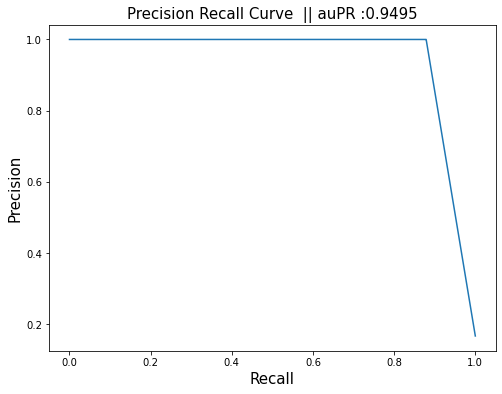

AUC : 0.9495 
Num anomalies 6432


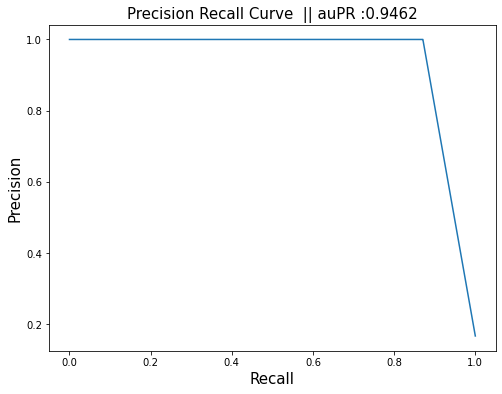

AUC : 0.9462 
Num anomalies 6432


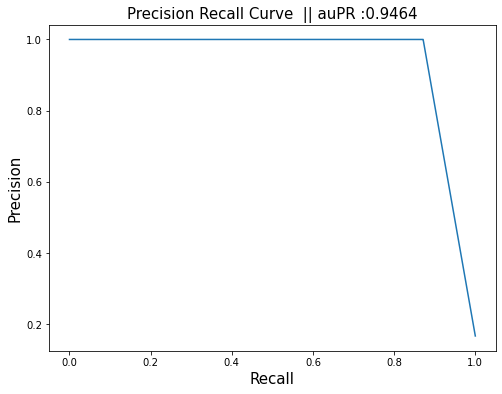

AUC : 0.9464 
Num anomalies 6432


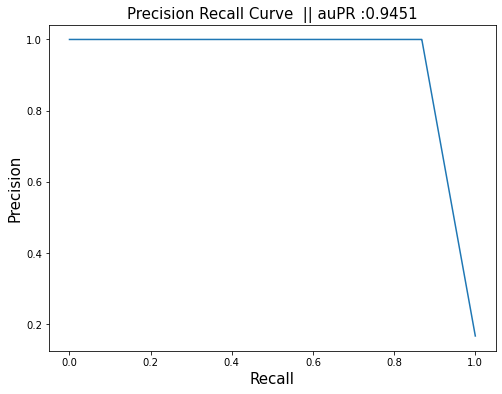

AUC : 0.9451 
Num anomalies 6432


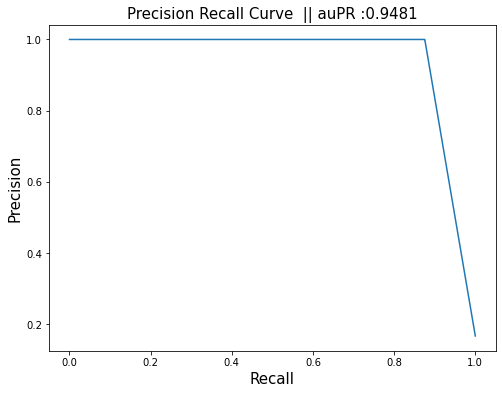

AUC : 0.9481 
 Mean AUC  0.9470612928220298
 AUC std  0.0015753278314171641


[0.9495359117821356,
 0.9461673205275414,
 0.9464264429317409,
 0.9450660503096933,
 0.948110738559038]

In [43]:
test_eval()

Num anomalies 6432


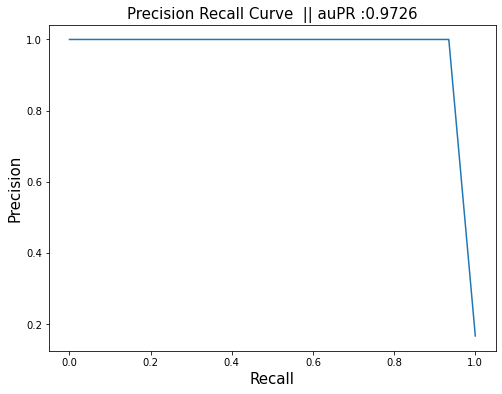

AUC : 0.9726 
Num anomalies 6432


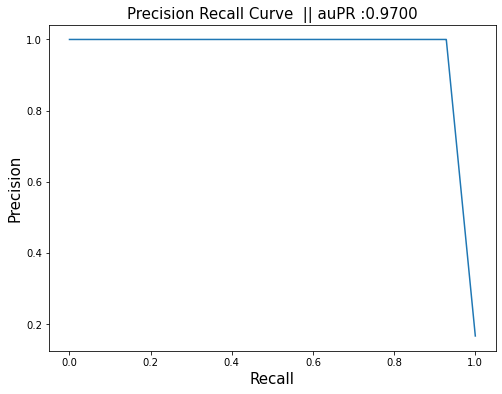

AUC : 0.9700 
Num anomalies 6432


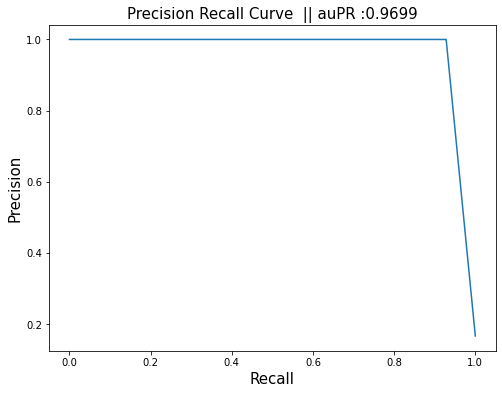

AUC : 0.9699 
Num anomalies 6432


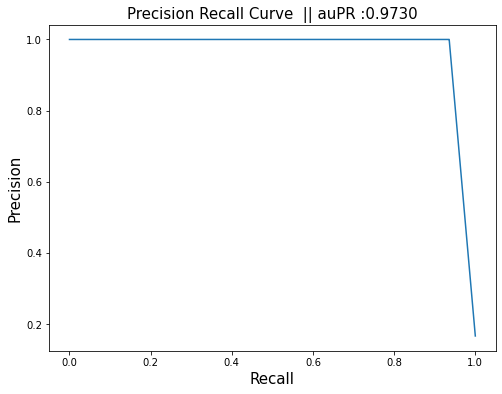

AUC : 0.9730 
Num anomalies 6432


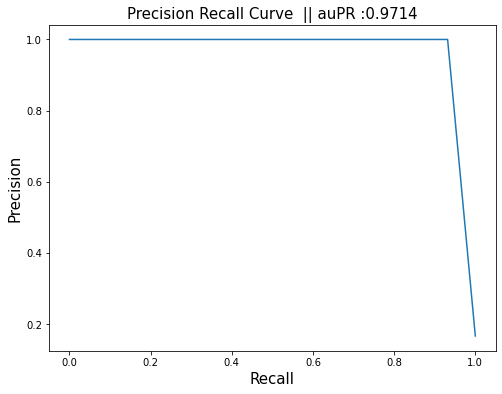

AUC : 0.9714 
 Mean AUC  0.9713985325851006
 AUC std  0.0012815641498309304


[0.9726295292103986,
 0.9700379996442805,
 0.9699080678319298,
 0.9730184540613853,
 0.9713986121775087]

In [21]:
test_eval()

# =========================================

In [44]:

test_norm_X = data_dict['test']

In [45]:
test_anom_df = data_dict['anom_1']
test_anom_X = test_anom_df.values
x1 = test_norm_X
x2 = test_anom_X

In [35]:
# pos,neg = model_data_fetcher.fetch_model_data('kddcup')

In [46]:

x0 = data_dict['train']

In [47]:
neg_x.shape

NameError: name 'neg' is not defined

In [48]:
neg1 = np.reshape(neg_x,[ neg_x.shape[0]* neg_x.shape[1] , neg_x.shape[2]])
np.random.shuffle(neg1)
neg1.shape

(750400, 114)

In [49]:
x3 = neg1[:10000]

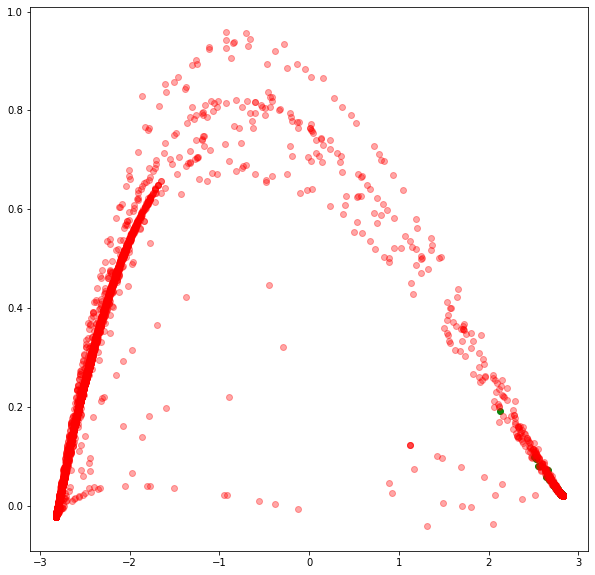

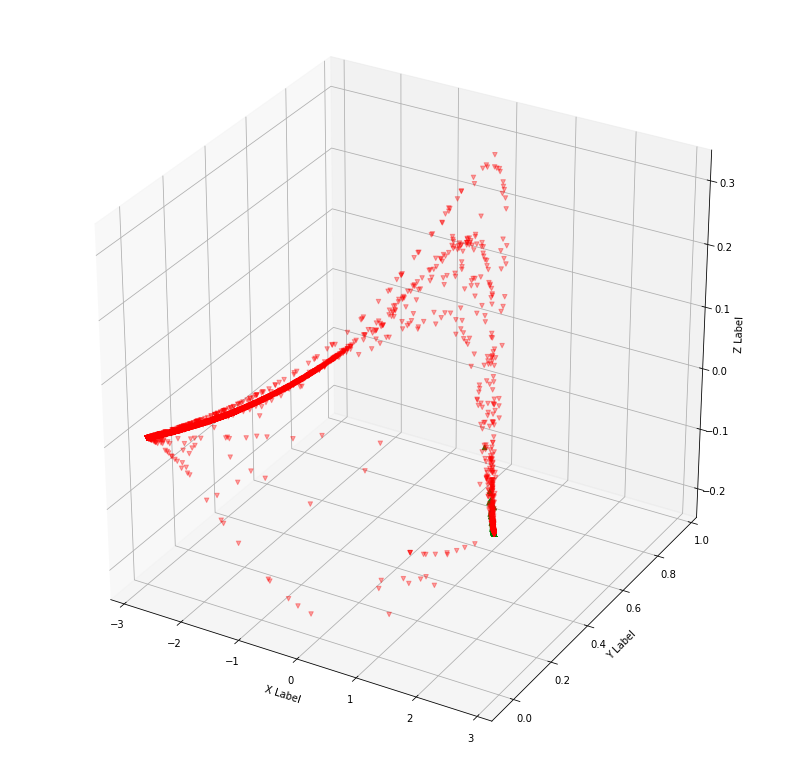

In [50]:
visualize( ae_model, x1, x2 )

In [41]:
ae_model.mode = 'test'

x1_scores = ae_model.get_score(x1)
x2_scores = ae_model.get_score(x2)

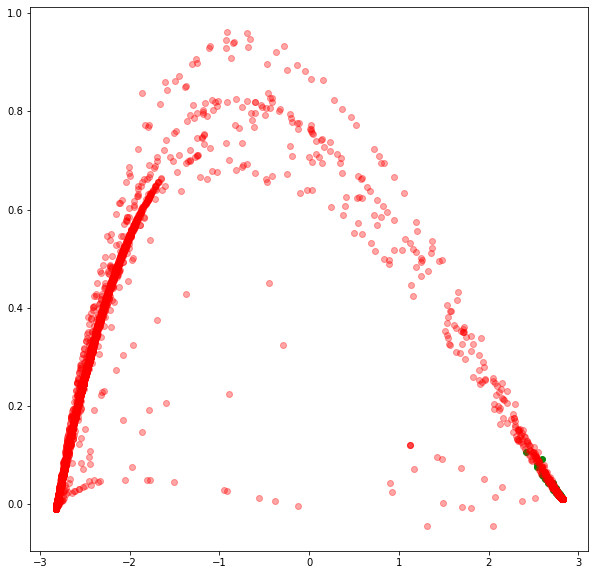

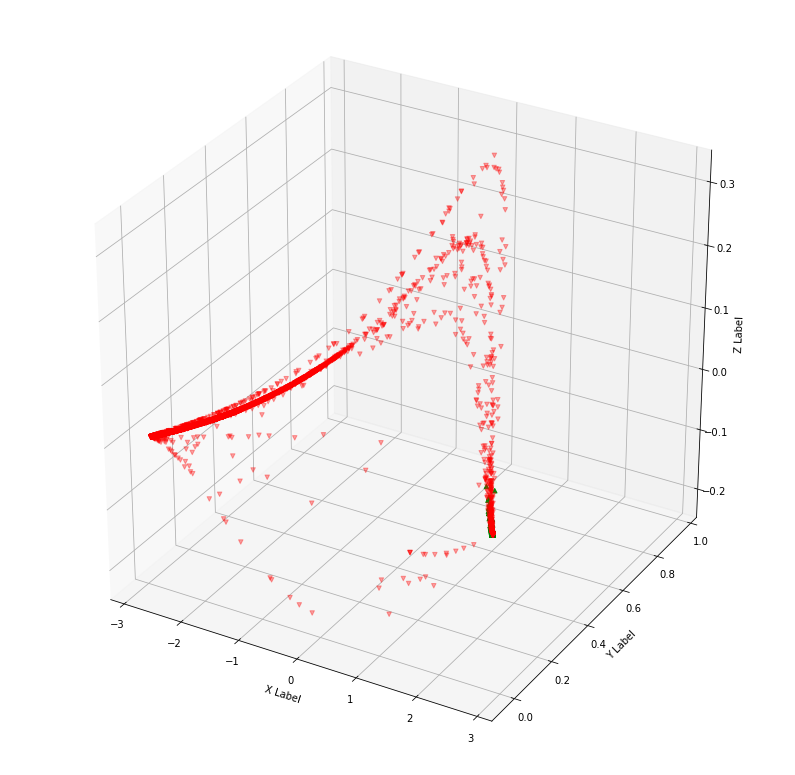

In [51]:
visualize( ae_model, x0, x2 )

In [43]:
x3_scores = ae_model.get_score(x3)
np.min(x3_scores), np.median(x3_scores), np.max(x3_scores)

(0.00030122657, 0.00030123346, 0.00030840922)

In [44]:
def _normalize_(val, _min,_max):
    return (val -_min)/(_max - _min)

In [45]:
import matplotlib.pyplot  as plt

In [46]:
# plt.boxplot(x1_scores)
# plt.show()
np.min(x2_scores), np.median(x2_scores), np.max(x2_scores)

(0.0003012303, 0.00030127252, 0.99995387)

Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432


 Mean AUC  0.9833125171695484
 AUC std  0.0006043721095057238


In [337]:
a = torch.FloatTensor(np.random.random([512,1,4]))
a.shape

Current device  >>  cuda


torch.Size([512, 1, 4])

In [341]:
a.squeeze(1).squeeze(1).shape

torch.Size([512, 4])

In [3]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)

In [35]:
from sklearn.datasets.samples_generator import make_blobs
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [82]:
centers = [(-5, -5, -6), (5, 5,0),(.25,1.25,2)]
cluster_std = [0.25,1.25,1.75]

X, y = make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)

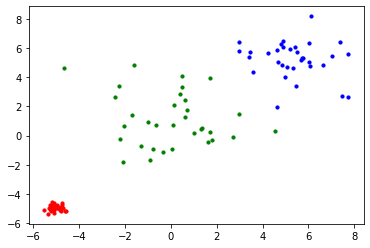

In [83]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red",  s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green",  s=10, label="Cluster1")


In [100]:
# Prepare initial centers using K-Means++ method.

def x_means(
    X,
    num_init_clusters = 8,
    visualize = True
):
    from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
    from pyclustering.cluster.xmeans import xmeans
    from pyclustering.cluster import cluster_visualizer
    from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
    from pyclustering.cluster import cluster_visualizer_multidim
    
    X = list(X)
    
    initial_centers = kmeans_plusplus_initializer(
        X, 
        amount_initial_centers
       
    ).initialize()

    start_centers = kmeans_plusplus_initializer(X, num_init_clusters).initialize()
   
    xmeans_instance = xmeans(X, start_centers, 20, ccore=True,  criterion = 0)
        

    # Run cluster analysis and obtain results.
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    print('Number of cluster centers calculated :', len(centers))

    if visualize :
        visualizer = cluster_visualizer_multidim()
        visualizer.append_clusters(clusters, X)
        visualizer.show()
    return centers,clusters

Number of cluster centers calculated : 4


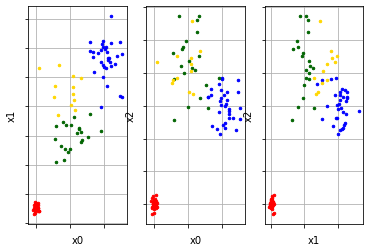

In [101]:

x_means(X,4)

In [31]:
# Prepare initial centers using K-Means++ method.


[array([5.35054598, 3.68771659])]


In [32]:
# Run cluster analysis and obtain results.
xmeans_instance_1.process()
clusters = xmeans_instance_1.get_clusters()
final_centers = xmeans_instance_1.get_centers()

In [33]:
final_centers

[[-4.957007090913727, -5.0115476154679115],
 [1.103508013001677, -1.0740079912115943],
 [1.0081270544323917, 2.3410526260307187],
 [4.899507476842758, 4.9839302284736595]]

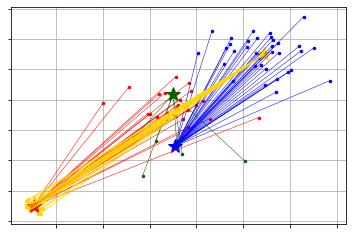

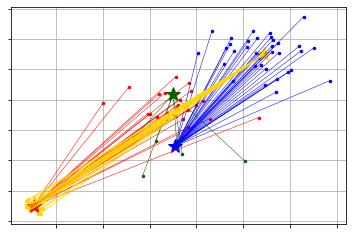

In [62]:
# Visualize obtained results
kmeans_visualizer.show_clusters(X, clusters, final_centers)